In [52]:
import pandas as pd
import numpy as np

# setting option to round floats to 2 sig figs and also avoid scientific notation

pd.set_option('display.float_format', '{:.2f}'.format) 

In [53]:
# reading in the data

df = pd.read_csv('May_25_2019.csv')

## Cleaning the data

In [54]:
# clearing whitespace from column names

df.rename(columns=lambda x: x.strip(), inplace=True)

In [55]:
# removing columsn that we have not been using thus far, if we think we need them later it's easy to add them

df = df.drop(["C/A", "LINENAME", "DIVISION", "DESC"], axis=1)

In [62]:
# adding days of the week so we can differentiate between week day and weekend

df.DATE = pd.to_datetime(df.DATE)
df['WEEKDAY'] = df.DATE.dt.dayofweek
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
df.WEEKDAY = df.WEEKDAY.apply(lambda x: days[x])

# do we need/want a column to identify if the day a workday or weekend?

# work_days = {0:'Workday',1:'Workday',2:'Workday',3:'Workday',4:'Workday',5:'Weekend',6:'Weekend'}
# df['WORKDAY'] = df.WEEKDAY.apply(lambda x: work_days[x])


In [66]:
df = df.reindex(columns=['UNIT', 'SCP', 'STATION', 'DATE','WEEKDAY', 'TIME', 'ENTRIES', 'EXITS'])
df.head()

,UNIT,SCP,STATION,DATE,WEEKDAY,TIME,ENTRIES,EXITS
0,R051,02-00-00,59 ST,2019-05-18,Sat,00:00:00,7062481,2393489
1,R051,02-00-00,59 ST,2019-05-18,Sat,04:00:00,7062505,2393492
2,R051,02-00-00,59 ST,2019-05-18,Sat,08:00:00,7062529,2393526
3,R051,02-00-00,59 ST,2019-05-18,Sat,12:00:00,7062627,2393612
4,R051,02-00-00,59 ST,2019-05-18,Sat,16:00:00,7062835,2393662


### Cleaning the data
#### Our first goal to find the average amount of entries and exits for the top 10 busiest stations

In [67]:
# group data by station, unit, scp, which allows us to look at the entries and exits for each individual turnstile.

turnstiles = df.groupby(['STATION','UNIT','SCP'])['ENTRIES', 'EXITS'].agg(np.ptp) 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
# df[(df.STATION == 'BAYCHESTER AV') & (df.UNIT == 'R292')].tail(50)

In [40]:
def outlier_check(df, station, scp, n=50):
    return df[(df.STATION == station) & (df.SCP == scp)].head(n)

# outlier_check(df,'3 AV-149 ST', '00-00-03', 30)

In [15]:
turnstiles.groupby('STATION').sum()

,ENTRIES,EXITS
STATION,,
1 AV,106522,118986
103 ST,197412,135063
103 ST-CORONA,126914,81631
104 ST,27947,12362
110 ST,67027,60516
...,...,...
WOODLAWN,43498,10468
WORLD TRADE CTR,108459,87582
WTC-CORTLANDT,77171,61683


In [16]:
# this represents the stations with the most ENTRIES for the week of May 11 to May 17 INCLUDING outliers
turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().sort_values('ENTRIES', ascending=False).head(10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,ENTRIES,EXITS
STATION,,
AVENUE N,1174424938,34072
FULTON ST,565091459,559818016
CANARSIE-ROCKAW,15479293,7615692
KINGSTON-THROOP,9062988,2874801
GRAND ST,7175848,5290683
14 ST,6912283,8795359
THIRTY ST,3147338,710471
KINGS HWY,1257615,1403837
34 ST-PENN STA,1040629,961122


In [17]:
turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,ENTRIES,EXITS
count,378.00,378.00
mean,4812406.74,1638228.71
std,66959173.51,28794010.74
min,10.00,0.00
25%,27929.00,18447.00
50%,55759.00,38006.00
75%,112556.75,90589.50
max,1174424938.00,559818016.00


In [30]:
# sets the boundaries for the outliers according to the 1.5 * IQR rule

upper = 115310.00 + 1.5*(115310.00 - 28549.00) 
lower = 28549.00 - 1.5*(115310.00 - 28549.00) 

# remove potential outliers
turnstiles = turnstiles[(turnstiles.ENTRIES < upper) & (turnstiles.ENTRIES > lower)]

# this represents the stations with the most ENTRIES and EXITS for the week of Jan 4 to Jan 10
top_10_entries, top_10_exits = (turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().sort_values('ENTRIES', ascending=False).head(10), 
 turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().sort_values('EXITS', ascending=False).head(10))

# average daily number of passengers entering and exiting
ave_daily_entries, ave_daily_exits = top_10_entries.ENTRIES/7, top_10_exits.EXITS/7
ave_daily_entries, ave_daily_exits

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


(STATION
 34 ST-PENN STA    148661.29
 GRD CNTRL-42 ST   125106.71
 23 ST             119674.43
 34 ST-HERALD SQ   109631.29
 42 ST-PORT AUTH    93562.57
 14 ST-UNION SQ     91299.00
 TIMES SQ-42 ST     88711.43
 FULTON ST          81943.86
 86 ST              77149.29
 125 ST             73278.43
 Name: ENTRIES, dtype: float64,
 STATION
 NEWARK HW BMEBE   208889.14
 TWENTY THIRD ST   156273.14
 34 ST-PENN STA    137303.14
 GRD CNTRL-42 ST   115618.57
 34 ST-HERALD SQ   101121.14
 JOURNAL SQUARE     88391.71
 TIMES SQ-42 ST     84086.43
 14 ST-UNION SQ     83806.00
 23 ST              81074.29
 JFK JAMAICA CT1    79223.71
 Name: EXITS, dtype: float64)

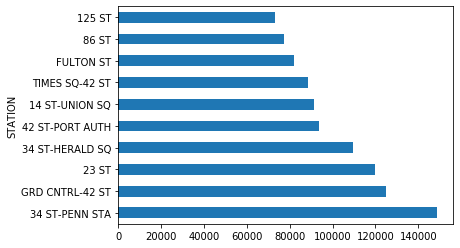

In [28]:
ave_daily_entries.plot(kind='barh')

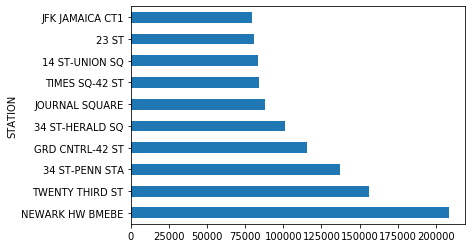

In [29]:
ave_daily_exits.plot(kind='barh')